# True FOM

In [1]:
# load in thekla data

In [104]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm



In [105]:
FOM_TS = ['456018']
TIMESTAMP = FOM_TS
RUN_NUMBER = '250925'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
# make directory
pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
folder_name = f'{pre_dir}/{FOM_TS}'
folder_s = Path(f'{folder_name}')
folder_s.mkdir(parents=True, exist_ok=True)
# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)
 

R250925: 456018
Loaded!


In [106]:
display(hdst)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
24,226716014,0,1.561308,348.308525,250,767,1,-3.575,-309.875,117.997121,...,127.048900,149.925,-155.375,296.930897,0.606233,0.198138,0.0,16.781818,16.679167,17.030071
35,226716022,0,1.667355,383.833994,347,1052,1,-126.975,-63.075,585.078154,...,764.482819,-34.675,183.725,610.822702,0.427723,0.163080,0.0,16.905000,17.081579,17.045575
62,226716043,0,1.594626,233.907795,279,1062,1,-158.075,-233.125,1053.811207,...,1114.175925,-34.675,-63.075,1098.298419,0.485382,0.260486,0.0,17.975000,17.865385,16.642752
81,226716052,0,1.480074,178.457349,190,644,1,212.125,-48.025,384.225441,...,410.863624,273.325,60.825,499.061495,0.993079,0.220753,0.0,17.368750,17.166667,17.759318
87,226716055,0,1.469495,251.446643,280,920,1,88.725,-94.175,512.023003,...,535.927934,134.375,-16.425,584.906413,0.418808,0.310144,0.0,17.975000,16.872727,16.012819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329193,131328046,0,1.609148,309.568205,313,985,1,-96.875,168.175,869.428301,...,897.755420,134.375,276.025,897.042789,0.588601,0.344013,0.0,17.261765,17.005000,17.233232
329220,131328065,0,1.616456,199.174941,229,790,1,119.825,214.825,500.653626,...,526.704739,227.675,276.025,593.604386,0.662582,0.577195,0.0,16.905000,17.005000,17.256323
329230,131328071,0,1.634003,264.588815,261,821,1,227.675,-78.125,451.982128,...,495.080391,319.975,45.275,594.649494,0.766157,0.203872,0.0,17.368750,16.905000,16.913350
329239,131328077,0,1.516815,381.578063,309,928,1,42.075,75.875,695.287633,...,858.217108,257.775,214.325,720.668518,0.551889,0.199457,0.0,17.261765,16.827273,17.349856


In [107]:
# load in the numpy array
signal_labels = np.load('MC_truth_FOM/positrons_250925.npy')
display(signal_labels)

array([226716009, 226716013, 226716015, ..., 131328085, 131328094,
       131328098])

In [108]:
# separate out signal and background
signal_df = hdst[hdst.event.isin(signal_labels)]
bckgnd_df = hdst[~hdst.event.isin(signal_labels)]

In [109]:
# check
print(f'Do the number of events make sense?')
print(f'{signal_df.event.nunique() + bckgnd_df.event.nunique() == hdst.event.nunique()}')

Do the number of events make sense?
True


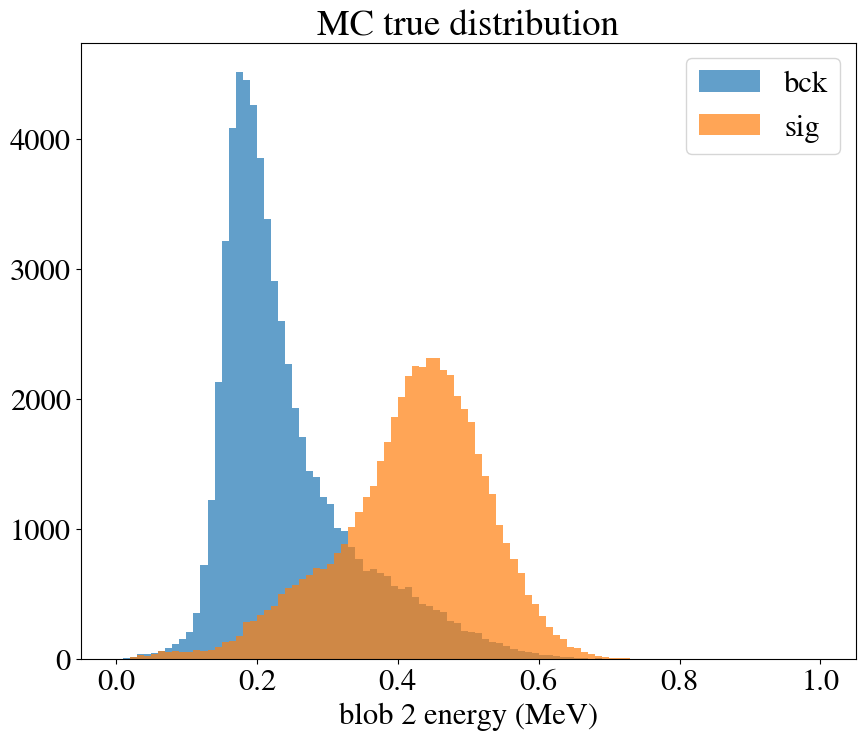

In [110]:
# signal vs background blob 2 distro
plt.hist(bckgnd_df.eblob2.values, label = 'bck', range = [0, 1], bins = 100, alpha = 0.7)
plt.hist(signal_df.eblob2.values, label = 'sig', range = [0, 1], bins = 100, alpha = 0.7)
plt.title('MC true distribution')
plt.xlabel('blob 2 energy (MeV)')
plt.legend()
plt.show()

In [111]:
cut_list = np.linspace(0, 0.6, 61)
q = FOM_func.true_fom_calc(signal_df, bckgnd_df, cut_list)

In [114]:
print(q[0])
print(q[1])

[1.0, 1.0, 1.0000243614261215, 0.9998598829492009, 0.999672211738268, 0.9995885399125192, 0.999255755314394, 0.9985837109905996, 0.9982103505583713, 0.9979939319634334, 0.998206296846262, 0.9989102268741811, 1.0005250725345167, 1.0054542944491742, 1.0145514496255623, 1.0318119600402509, 1.0599145189504209, 1.100202880973846, 1.150670147494116, 1.205984558043687, 1.2683233663719637, 1.3334440251168889, 1.3993832320189574, 1.4642210991881732, 1.5285627958950472, 1.5916231558817402, 1.6510777114650212, 1.70844876898615, 1.760626494152227, 1.816495948023612, 1.8717689955553276, 1.9310521663145104, 1.9807427430567832, 2.0336671837936384, 2.077339599542128, 2.1123931038473964, 2.1358349637119294, 2.1636753852404467, 2.1833695805673727, 2.1972861920595914, 2.190464534296313, 2.1731987160032267, 2.1538244033181204, 2.1139714402561074, 2.0612482397646503, 1.999008533353197, 1.9265785406189724, 1.8583702660788084, 1.7598702931069627, 1.6661480495693008, 1.5459632760593434, 1.4263924442995495, 1.

Text(0.5, 1.0, 'True FOM')

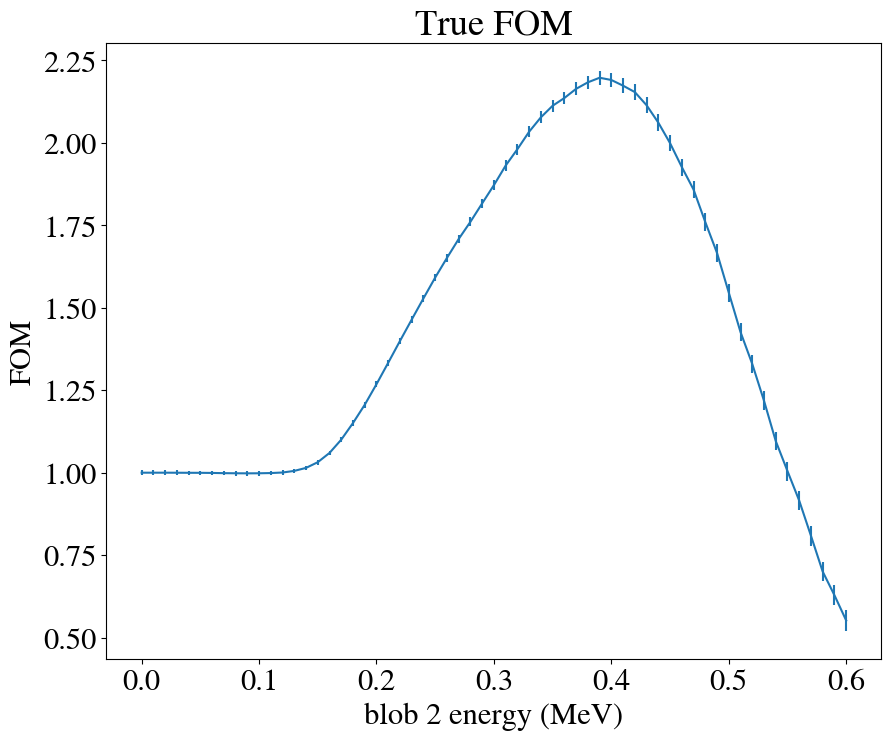

In [112]:
plt.errorbar(cut_list, q[0], yerr = q[1])
plt.xlabel('blob 2 energy (MeV)')
plt.ylabel('FOM')
plt.title('True FOM')

In [30]:
MC_456018 = [1.0, 1.0, 1.0000273618300308, 1.0000102064767737, 0.9999315754970243, 0.999844945973679, 0.9995027723147519, 0.9991802129186281, 0.9989272459889326, 0.998916875265821, 0.9995656862970909, 1.0001950198644936, 1.0018718300063165, 1.00657290294864, 1.014526954885366, 1.0302285690526913, 1.0546571560010458, 1.0887457724962037, 1.131604606067816, 1.1761248313217196, 1.2246013193973817, 1.2748071208790974, 1.3228291249666928, 1.3682626074789588, 1.4117069697894724, 1.450972558976176, 1.4882378276357258, 1.5231615251906616, 1.5505830675329646, 1.5791899359869546, 1.607970314468629, 1.6371670765413824, 1.660094165309357, 1.6788641891595388, 1.6922239267722416, 1.699861126709263, 1.6997686094402609, 1.6998303264675054, 1.698711717680303, 1.6927510828705188, 1.6739700151867287, 1.6410746313681333, 1.6042139687327037, 1.5628217415865937, 1.51133051165538, 1.457371396278447, 1.397631192621088, 1.3461898496522597, 1.2719406651196339, 1.2091244937926922, 1.11334159710724]
cl_456018 = np.linspace(0, 0.5, 51)

data_456018 = [1.0, 1.0, 0.999890941493442, 0.999819018500548, 0.9996276061401524, 0.9997467834907232, 0.9995058731992829, 0.9989033391407843, 0.9998090978056167, 1.0017678864888278, 1.0046837183945212, 1.0100737657039505, 1.0186305621868883, 1.0322130991367742, 1.0513772398057408, 1.081690677028547, 1.1180124645514646, 1.160688036473442, 1.2069706922658618, 1.2604136359065188, 1.3119109566621638, 1.3636718600771673, 1.412263534159618, 1.466991882686507, 1.5151936460603417, 1.5654663885273588, 1.6124525946304273, 1.6487039147113352, 1.6928819313133372, 1.7384962601026634, 1.778478734221356, 1.8128581329462452, 1.8450793385744853, 1.8633543186845432, 1.8763769415162062, 1.884191817870631, 1.9009559289758344, 1.8953273472214838, 1.8900346326849518, 1.8711289849822543, 1.8448178873369625, 1.7826457678128909, 1.757662265086213, 1.6977094064735911, 1.62306375807771, 1.5375570163131964, 1.4501092976191574, 1.3851209754954383, 1.3083062240464582, 1.2336313088356097, 1.1575626445836893]

Text(0, 0.5, 'FOM')

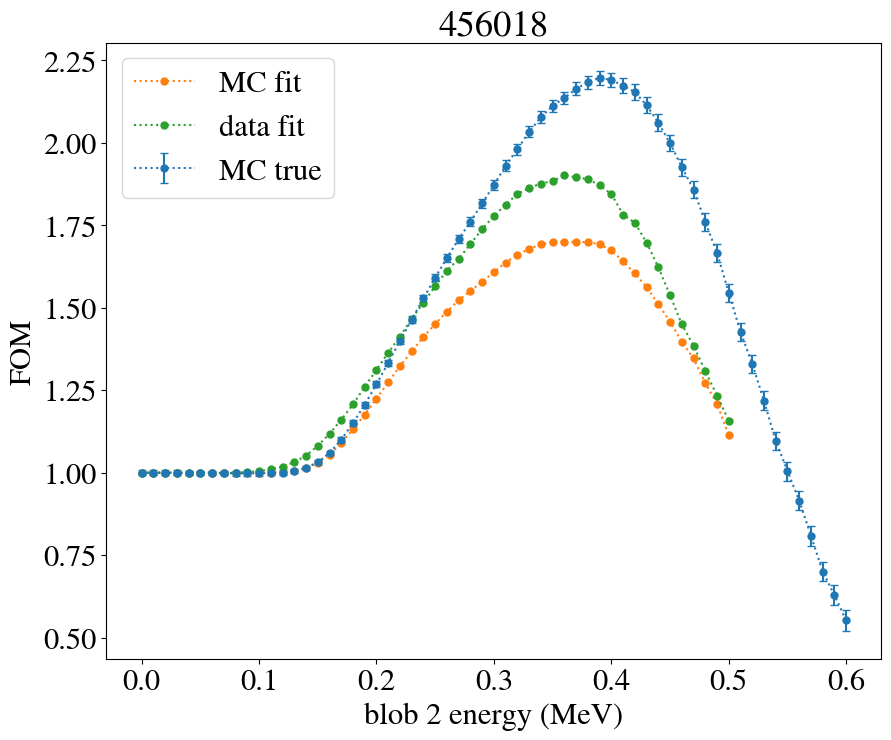

In [43]:
#plt.errorbar(cut_list, q[0], yerr = q[1], label = 'True')
plt.errorbar(cut_list, q[0], yerr=q[1], fmt='o', markersize=5, capsize=3, linestyle='dotted', label='MC true')
plt.plot(cl_456018, MC_456018, linestyle='dotted', marker='o', markersize=5, label='MC fit')
plt.plot(cl_456018, data_456018,linestyle='dotted', marker='o', markersize=5, label = 'data fit')
plt.xlabel('blob 2 energy (MeV)')
plt.title('456018')
plt.legend()
plt.ylabel('FOM')


In [24]:
np.save('MC_truth_FOM/FOM_MC_true', q)

/scicomp/builds/Rocky/8.7/Common/software/Anaconda3/2023.03-1/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
p = np.load('MC_truth_FOM/FOM_MC_true.npy', allow_pickle = True)
print(p)

[list([1.0, 1.0, 1.0000243614261215, 0.9998598829492009, 0.999672211738268, 0.9995885399125192, 0.999255755314394, 0.9985837109905996, 0.9982103505583713, 0.9979939319634334, 0.998206296846262, 0.9989102268741811, 1.0005250725345167, 1.0054542944491742, 1.0145514496255623, 1.0318119600402509, 1.0599145189504209, 1.100202880973846, 1.150670147494116, 1.205984558043687, 1.2683233663719637, 1.3334440251168889, 1.3993832320189574, 1.4642210991881732, 1.5285627958950472, 1.5916231558817402, 1.6510777114650212, 1.70844876898615, 1.760626494152227, 1.816495948023612, 1.8717689955553276, 1.9310521663145104, 1.9807427430567832, 2.0336671837936384, 2.077339599542128, 2.1123931038473964, 2.1358349637119294, 2.1636753852404467, 2.1833695805673727, 2.1972861920595914, 2.190464534296313, 2.1731987160032267, 2.1538244033181204, 2.1139714402561074, 2.0612482397646503, 1.999008533353197, 1.9265785406189724, 1.8583702660788084, 1.7598702931069627, 1.6661480495693008, 1.5459632760593434, 1.42639244429954

## separate out into the three sections

In [116]:

sig_sec_1 = signal_df[signal_df.z_ave < 250]
sig_sec_2 = signal_df[(signal_df.z_ave > 250) & (signal_df.z_ave <= 750)]
sig_sec_3 = signal_df[(signal_df.z_ave > 750) & (signal_df.z_ave <= 1500)]


bck_sec_1 = bckgnd_df[bckgnd_df.z_ave < 250]
bck_sec_2 = bckgnd_df[(bckgnd_df.z_ave > 250) & (bckgnd_df.z_ave <= 750)]
bck_sec_3 = bckgnd_df[(bckgnd_df.z_ave > 750) & (bckgnd_df.z_ave <= 1500)]



In [117]:
q_s1 = FOM_func.true_fom_calc(sig_sec_1, bck_sec_1, cut_list)
q_s2 = FOM_func.true_fom_calc(sig_sec_2, bck_sec_2, cut_list)
q_s3 = FOM_func.true_fom_calc(sig_sec_3, bck_sec_3, cut_list)

In [120]:
print(f'seg_1 FOM:\n{q_s1[0]}\nFOM error:\n{q_s1[1]}')
print(f'\n')
print(f'seg_2 FOM:\n{q_s2[0]}\nFOM error:\n{q_s2[1]}')
print(f'\n')
print(f'seg_3 FOM:\n{q_s3[0]}\nFOM error:\n{q_s3[1]}')

seg_1 FOM:
[1.0, 1.0, 1.0, 0.9996358166174811, 0.9995884822034042, 0.9994609995359013, 0.9996108300940629, 0.9981119393436604, 0.9979078205412445, 0.9976233644946978, 0.9972112015781657, 0.9965205577501492, 0.995910481883297, 0.9984399249458639, 1.003015845544626, 1.0169032941703053, 1.0404676991124158, 1.0799994903061774, 1.1344178282971078, 1.188559186821133, 1.2468633851219344, 1.3105493288105463, 1.3754713321130743, 1.4498522593987935, 1.5235648432443811, 1.5811332119637034, 1.638307899709094, 1.6994355583921825, 1.7390169854326167, 1.7908276975218882, 1.833865177683637, 1.8864713807404438, 1.934085701213247, 1.9832270810909212, 2.0455091873469824, 2.0893456934766057, 2.1307061190414887, 2.174242264885191, 2.207185103809422, 2.2532523893067347, 2.273531309572014, 2.285895519905396, 2.298010948013342, 2.302769014401779, 2.3122209351655805, 2.259813353892436, 2.186881972215845, 2.1171160247905445, 2.0340707530157327, 1.9756469579624552, 1.9081113220833872, 1.8144478274846234, 1.71685